Detailed spectra of astrophysical objects sometimes allow for determinations of how much of the gas is moving with a certain velocity along the line of sight, thanks to Doppler shifting of spectral lines. This enables "data cubes" to be created in RA, Dec, and line-of-sight velocity space. In yt, we can use the `PPVCube` analysis module to project fields along a given line of sight traveling at different line-of-sight velocities, to "mock-up" what would be seen in observations.

In [1]:
import numpy as np

import yt
import yt.units as u
from yt.extensions.astro_analysis.ppv_cube.api import PPVCube

To demonstrate this functionality, we'll create a simple unigrid dataset from scratch of a rotating disk. We create a thin disk in the x-y midplane of the domain of three cells in height in either direction, and a radius of 10 kpc. The density and azimuthal velocity profiles of the disk as a function of radius will be given by the following functions:

Density: $\rho(r) \propto r^{\alpha}$

Velocity: $v_{\theta}(r) \propto \frac{r}{1+(r/r_0)^{\beta}}$

where for simplicity we won't worry about the normalizations of these profiles. 

First, we'll set up the grid and the parameters of the profiles:

In [2]:
# increasing the resolution will make the images in this notebook more visually appealing
nx,ny,nz = (64, 64, 64) # domain dimensions
R = 10. # outer radius of disk, kpc
r_0 = 3. # scale radius, kpc
beta = 1.4 # for the tangential velocity profile
alpha = -1. # for the radial density profile
x, y = np.mgrid[-R:R:nx*1j,-R:R:ny*1j] # cartesian coordinates of x-y plane of disk
r = np.sqrt(x*x+y*y) # polar coordinates
theta = np.arctan2(y, x) # polar coordinates

Second, we'll construct the data arrays for the density, temperature, and velocity of the disk. Since we have the tangential velocity profile, we have to use the polar coordinates we derived earlier to compute `velx` and `vely`. Everywhere outside the disk, all fields are set to zero.  

In [3]:
dens = np.zeros((nx,ny,nz))
dens[:,:,nz//2-3:nz//2+3] = (r**alpha).reshape(nx,ny,1) # the density profile of the disk
temp = np.zeros((nx,ny,nz))
temp[:,:,nz//2-3:nz//2+3] = 1.0e5 # Isothermal
vel_theta = 100.*r/(1.+(r/r_0)**beta) # the azimuthal velocity profile of the disk
velx = np.zeros((nx,ny,nz))
vely = np.zeros((nx,ny,nz))
velx[:,:,nz//2-3:nz//2+3] = (-vel_theta*np.sin(theta)).reshape(nx,ny,1) # convert polar to cartesian
vely[:,:,nz//2-3:nz//2+3] = (vel_theta*np.cos(theta)).reshape(nx,ny,1) # convert polar to cartesian
dens[r > R] = 0.0
temp[r > R] = 0.0
velx[r > R] = 0.0
vely[r > R] = 0.0

Finally, we'll package these data arrays up into a dictionary, which will then be shipped off to `load_uniform_grid`. We'll define the width of the grid to be `2*R` kpc, which will be equal to 1  `code_length`. 

In [4]:
data = {}
data["density"] = (dens,"g/cm**3")
data["temperature"] = (temp, "K")
data["velocity_x"] = (velx, "km/s")
data["velocity_y"] = (vely, "km/s")
data["velocity_z"] = (np.zeros((nx,ny,nz)), "km/s") # zero velocity in the z-direction
bbox = np.array([[-0.5,0.5],[-0.5,0.5],[-0.5,0.5]]) # bbox of width 1 on a side with center (0,0,0)
ds = yt.load_uniform_grid(data, (nx,ny,nz), length_unit=(2*R,"kpc"), nprocs=1, bbox=bbox)

yt : [INFO     ] 2023-10-02 09:48:06,889 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-10-02 09:48:06,891 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2023-10-02 09:48:06,892 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2023-10-02 09:48:06,893 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2023-10-02 09:48:06,894 Parameters: cosmological_simulation   = 0


To get a sense of what the data looks like, we'll take a slice through the middle of the disk:

In [7]:
slc = yt.SlicePlot(
    ds,
    "z",
    fields=[
        ("gas", "density"),
        ("gas", "velocity_x"),
        ("gas", "velocity_y"),
        ("gas", "velocity_magnitude"),
    ]
)

yt : [INFO     ] 2023-10-02 09:51:15,566 xlim = -0.500000 0.500000
yt : [INFO     ] 2023-10-02 09:51:15,567 ylim = -0.500000 0.500000
yt : [INFO     ] 2023-10-02 09:51:15,571 xlim = -0.500000 0.500000
yt : [INFO     ] 2023-10-02 09:51:15,573 ylim = -0.500000 0.500000
yt : [INFO     ] 2023-10-02 09:51:15,575 Making a fixed resolution buffer of (('gas', 'velocity_magnitude')) 800 by 800
yt : [INFO     ] 2023-10-02 09:51:15,795 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-10-02 09:51:16,011 Making a fixed resolution buffer of (('gas', 'velocity_y')) 800 by 800
yt : [INFO     ] 2023-10-02 09:51:16,235 Making a fixed resolution buffer of (('gas', 'velocity_x')) 800 by 800



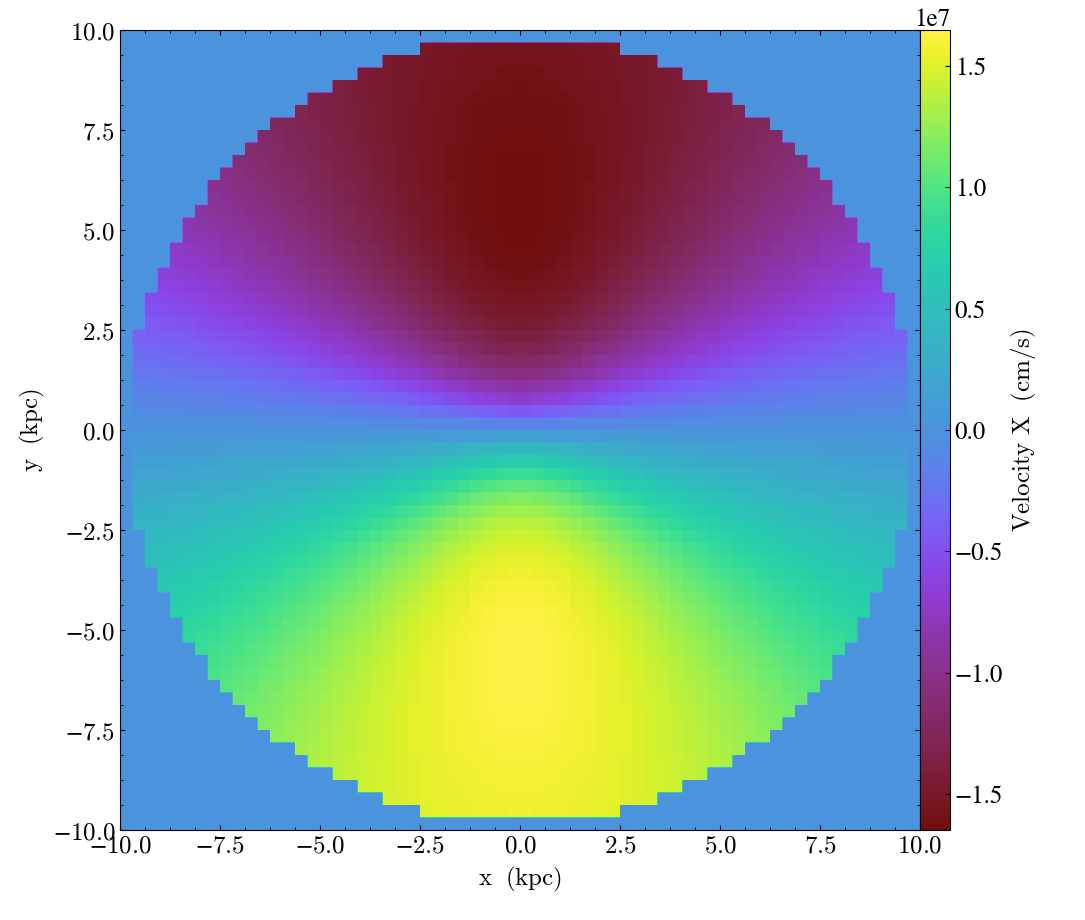
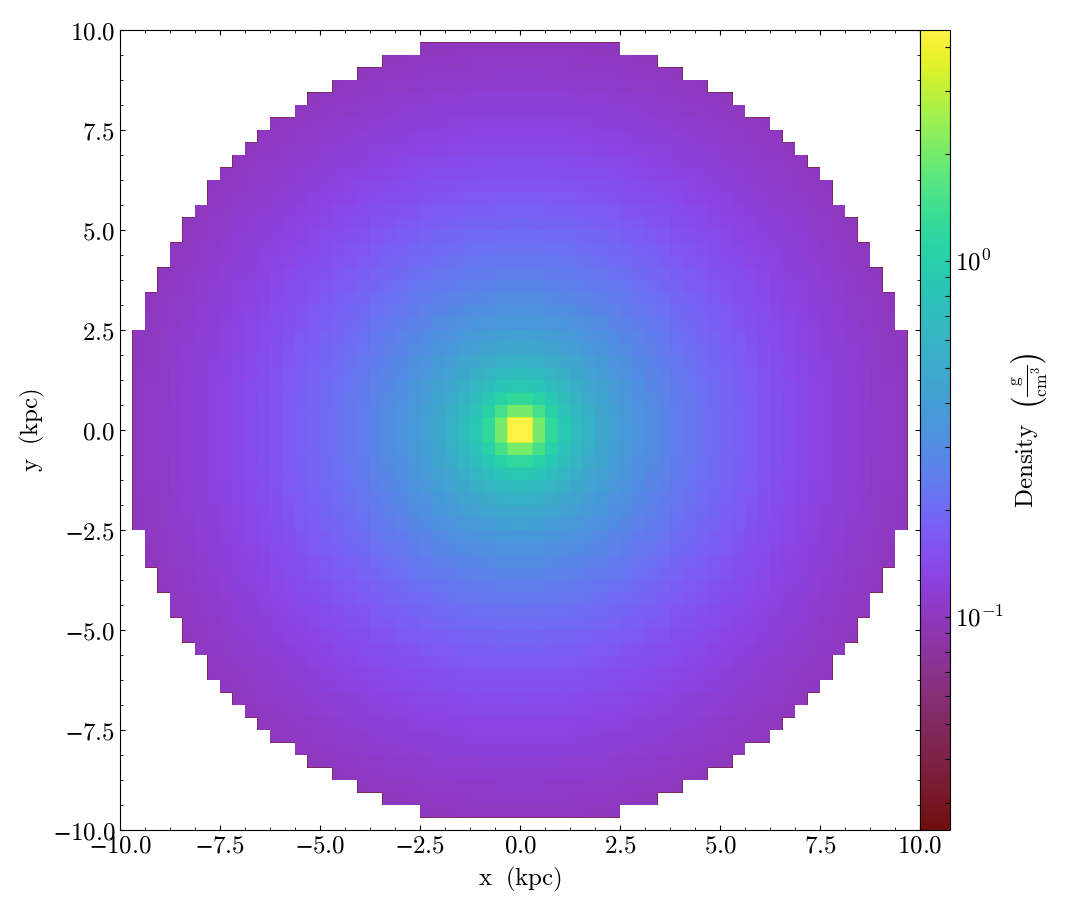
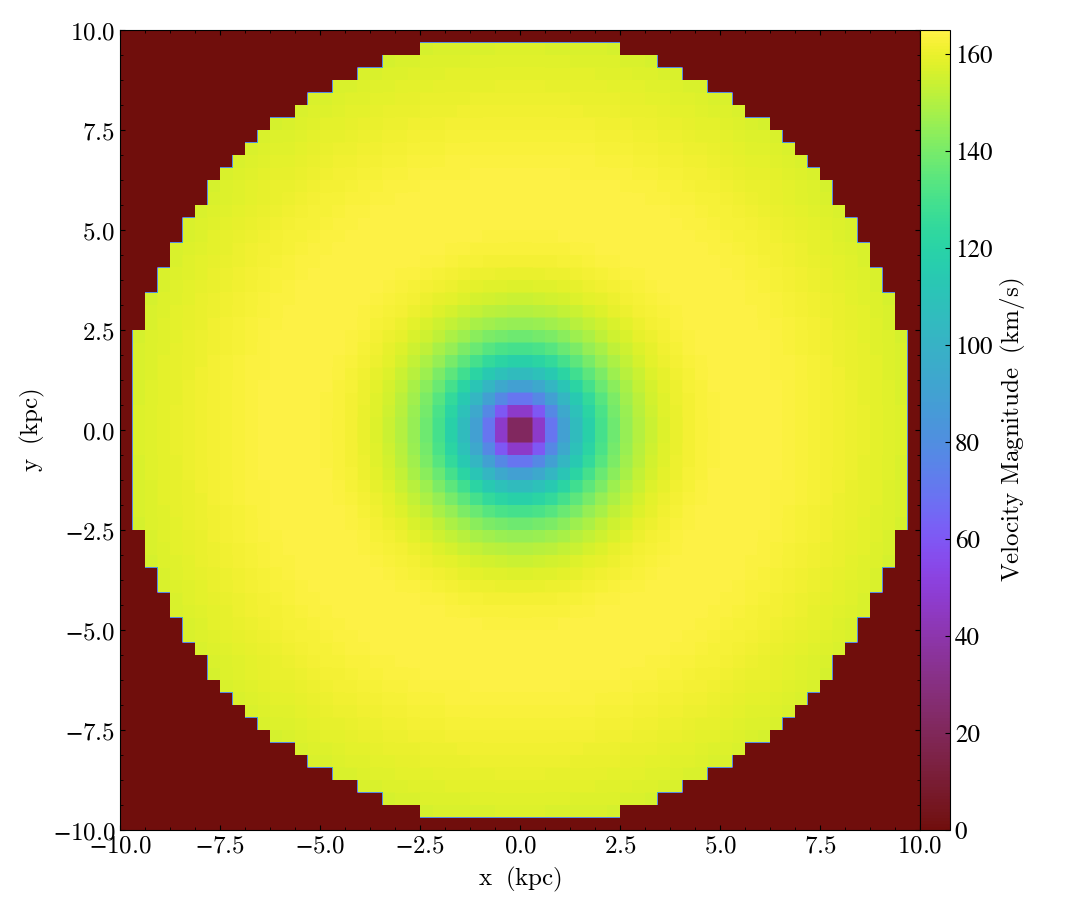
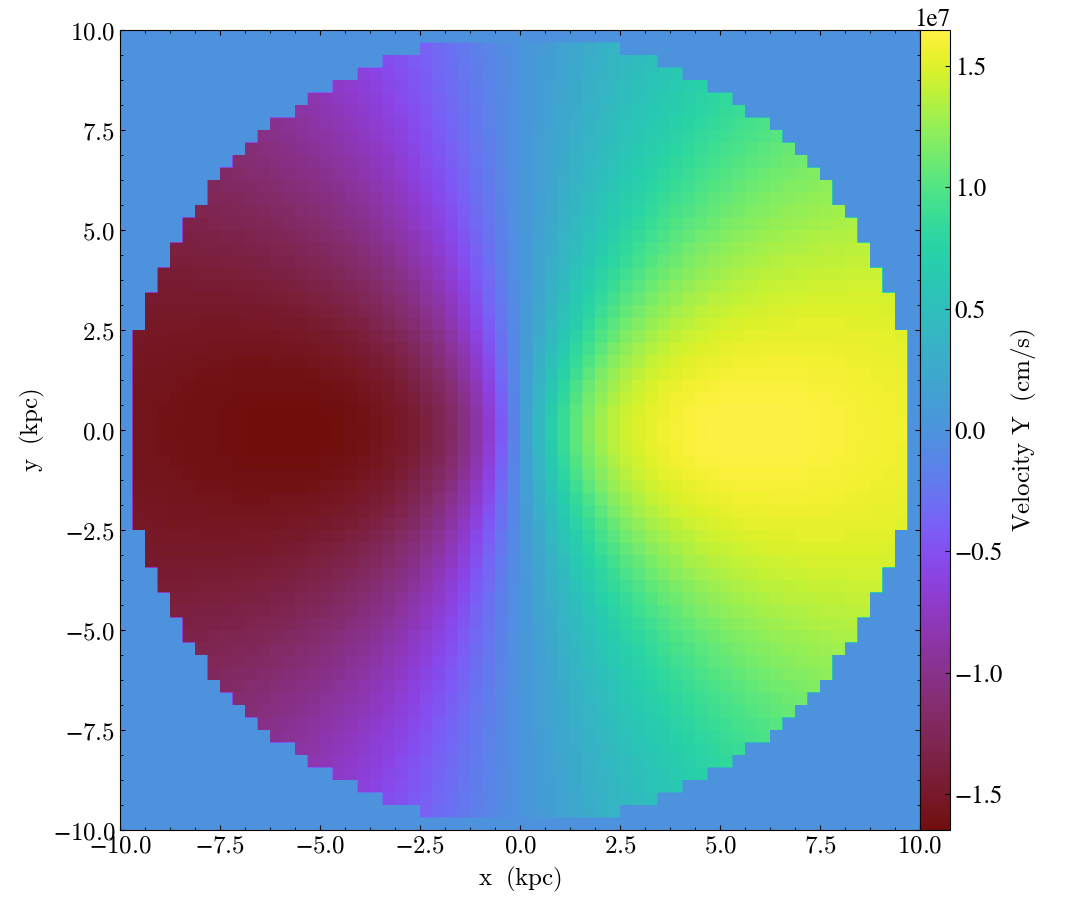

In [8]:
slc.set_log(("gas", "velocity_x"), False)
slc.set_log(("gas", "velocity_y"), False)
slc.set_log(("gas", "velocity_magnitude"), False)
slc.set_unit(("gas", "velocity_magnitude"), "km/s")
slc.show()

Which shows a rotating disk with a specific density and velocity profile. Now, suppose we wanted to look at this disk galaxy from a certain orientation angle, and simulate a 3D FITS data cube where we can see the gas that is emitting at different velocities along the line of sight. We can do this using the `PPVCube` class. First, let's assume we rotate our viewing angle 60 degrees from face-on, from along the z-axis into the x-axis. We'll create a normal vector:

In [9]:
i = 60.*np.pi/180.
L = [np.sin(i),0.0,np.cos(i)]

Next, we need to specify a field that will serve as the "intensity" of the emission that we see. For simplicity, we'll simply choose the gas density as this field, though it could be any field (including derived fields) in principle. We also need to choose the bounds in line-of-sight velocity that the data will be binned into, which is a 4-tuple in the shape of `(vmin, vmax, nbins, units)`, which specifies a linear range of `nbins` velocity bins from `vmin` to `vmax` in units of `units`. We may also optionally specify the dimensions of the data cube with the `dims` argument.

In [10]:
cube = PPVCube(ds, L, "density", (-150.,150.,50,"km/s"), dims=200, method="sum")

Generating cube.: 100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


Following this, we can now write this cube to a FITS file. The x and y axes of the file can be in length units, which can be optionally specified by `length_unit`:

In [11]:
cube.write_fits("cube.fits", overwrite=True, length_unit="kpc")

yt : [INFO     ] 2023-10-02 09:51:37,535 Making a FITS image of field density


Or one can use the `sky_scale` and `sky_center` keywords to set up the coordinates in RA and Dec:

In [12]:
sky_scale = (1.0, "arcsec/kpc")
sky_center = (30., 45.) # RA, Dec in degrees
cube.write_fits("cube_sky.fits", overwrite=True, sky_scale=sky_scale, sky_center=sky_center)

Now, we'll look at the FITS dataset in yt and look at different slices along the velocity axis, which is the "z" axis:

In [11]:
ds_cube = yt.load("cube.fits")

yt : [WARNING  ] 2017-08-10 16:21:43,858 Cannot find time
yt : [INFO     ] 2017-08-10 16:21:43,860 Detected these axes: LINEAR LINEAR VOPT 
yt : [INFO     ] 2017-08-10 16:21:43,867 Found length units of kpc.
yt : [INFO     ] 2017-08-10 16:21:43,878 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-10 16:21:43,879 Parameters: domain_dimensions         = [200 200  50]
yt : [INFO     ] 2017-08-10 16:21:43,880 Parameters: domain_left_edge          = [ 0.5  0.5  0.5]
yt : [INFO     ] 2017-08-10 16:21:43,881 Parameters: domain_right_edge         = [ 200.5  200.5   50.5]
yt : [INFO     ] 2017-08-10 16:21:43,882 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2017-08-10 16:21:43,894 Adding field density to the list of fields.
yt : [INFO     ] 2017-08-10 16:21:44,059 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,060 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,061 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,062 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,063 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



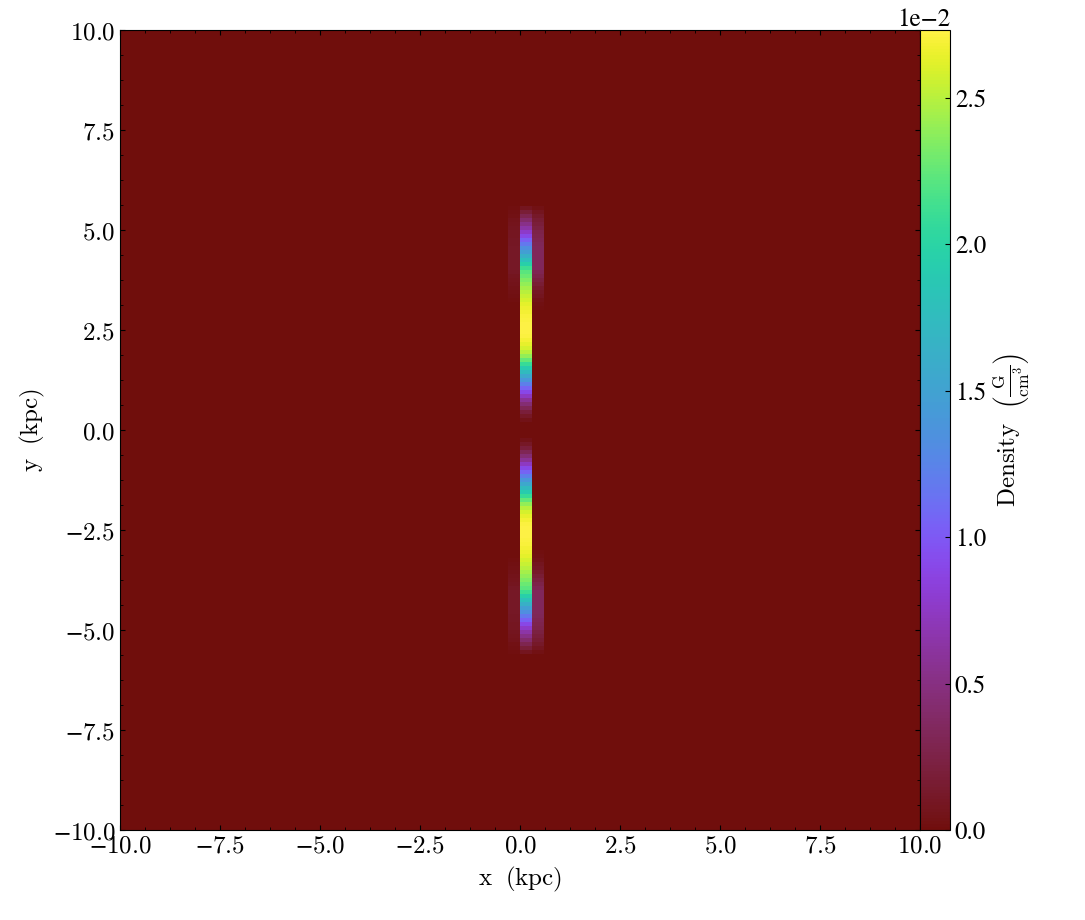

In [12]:
# Specifying no center gives us the center slice
slc = yt.SlicePlot(ds_cube, "z", ["density"])
slc.show()

yt : [INFO     ] 2017-08-10 16:21:44,985 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,985 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,987 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,987 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:44,989 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



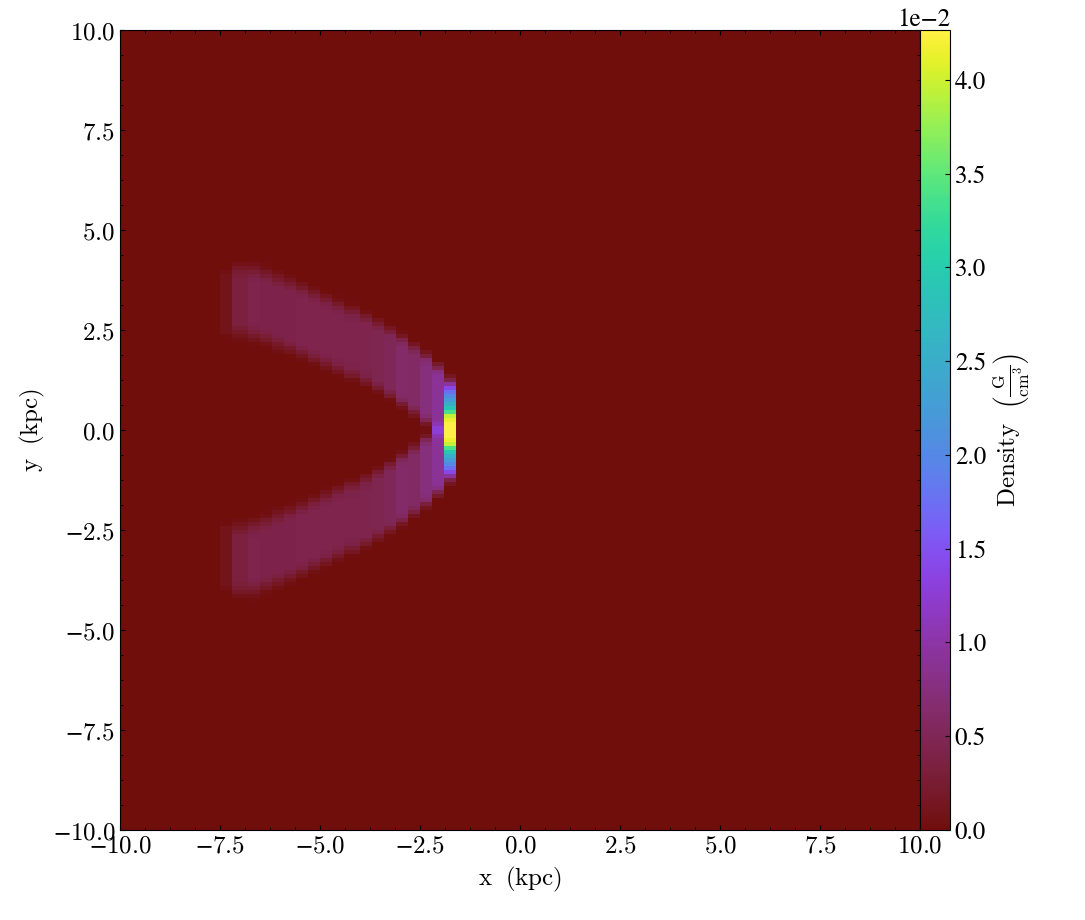

In [13]:
# Picking different velocities for the slices
new_center = ds_cube.domain_center
new_center[2] = ds_cube.spec2pixel(-100.*u.km/u.s)
slc = yt.SlicePlot(ds_cube, "z", ["density"], center=new_center)
slc.show()

yt : [INFO     ] 2017-08-10 16:21:45,936 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:45,937 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:45,938 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:45,939 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:45,940 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



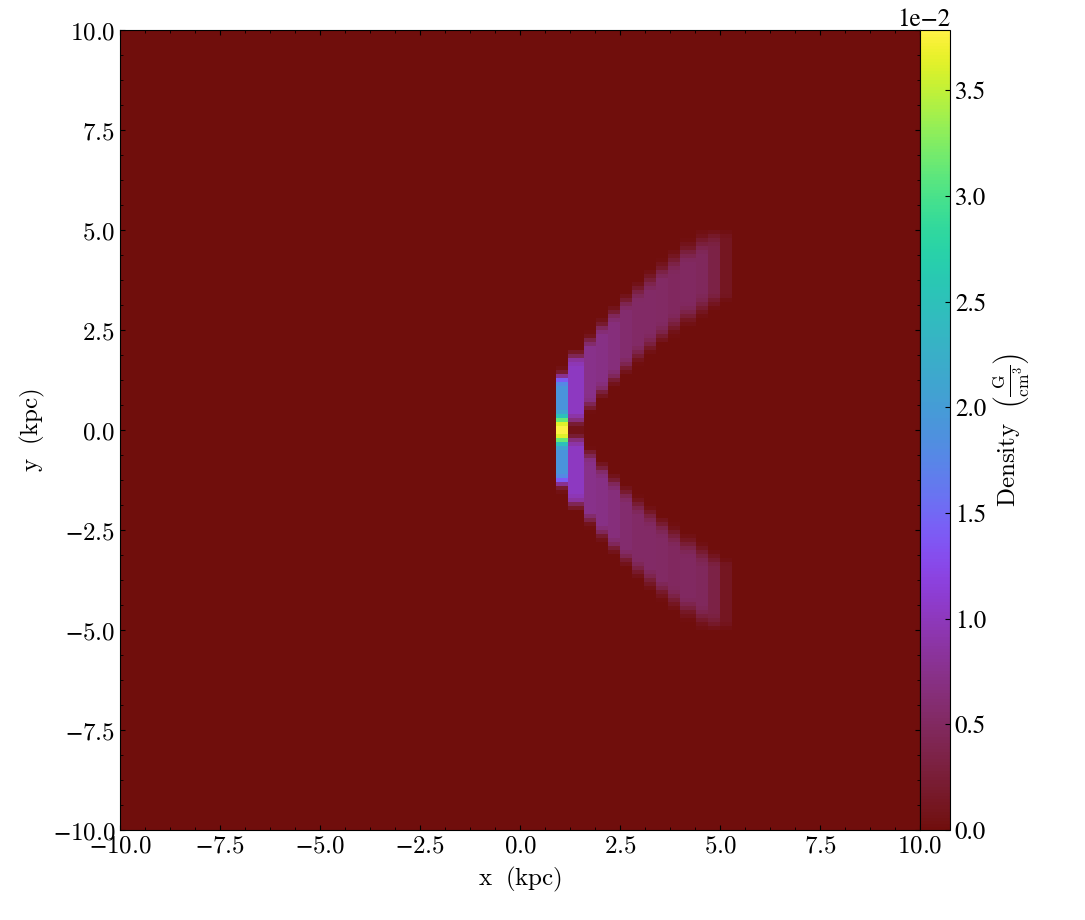

In [14]:
new_center[2] = ds_cube.spec2pixel(70.0*u.km/u.s)
slc = yt.SlicePlot(ds_cube, "z", ["density"], center=new_center)
slc.show()

yt : [INFO     ] 2017-08-10 16:21:46,792 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:46,793 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:46,794 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:46,795 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:46,796 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



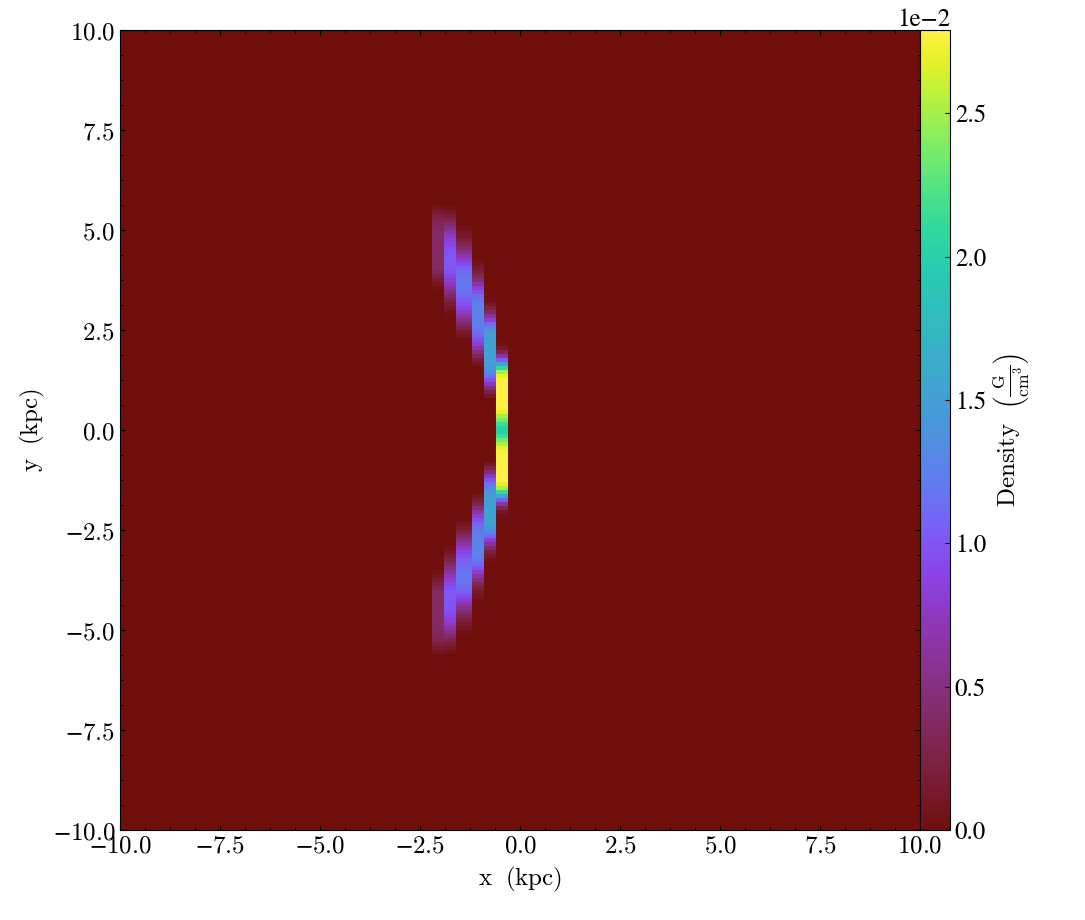

In [15]:
new_center[2] = ds_cube.spec2pixel(-30.0*u.km/u.s)
slc = yt.SlicePlot(ds_cube, "z", ["density"], center=new_center)
slc.show()

If we project all the emission at all the different velocities along the z-axis, we recover the entire disk:

yt : [INFO     ] 2017-08-10 16:21:47,768 Projection completed
yt : [INFO     ] 2017-08-10 16:21:47,769 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:47,770 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:47,772 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:47,772 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:47,774 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



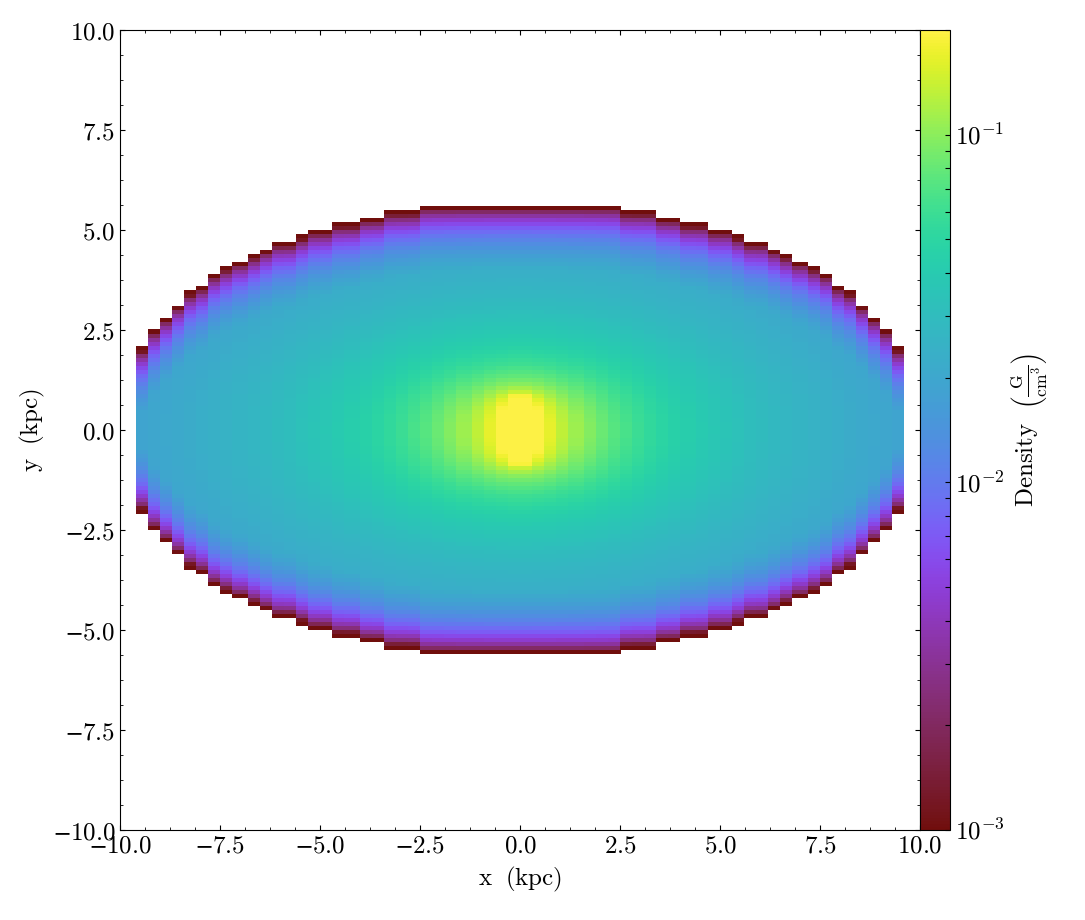

In [16]:
prj = yt.ProjectionPlot(ds_cube, "z", ["density"], method="sum")
prj.set_log("density", True)
prj.set_zlim("density", 1.0e-3, 0.2)
prj.show()

The `thermal_broad` keyword allows one to simulate thermal line broadening based on the temperature, and the `atomic_weight` argument is used to specify the atomic weight of the particle that is doing the emitting.

In [17]:
cube2 = PPVCube(ds, L, "density", (-150.,150.,50,"km/s"), dims=200, thermal_broad=True,
                atomic_weight=12.0, method="sum")
cube2.write_fits("cube2.fits", overwrite=True, length_unit="kpc")

Generating cube.: 100%|██████████| 50/50 [00:04<00:00, 12.30it/s]
yt : [INFO     ] 2017-08-10 16:21:52,803 Making a FITS image of field density
yt : [WARNING  ] 2017-08-10 16:21:52,816 update_all_headers is deprecated. Use update_header('all', key, value) instead.
yt : [WARNING  ] 2017-08-10 16:21:52,816 update_all_headers is deprecated. Use update_header('all', key, value) instead.


Taking a slice of this cube shows:

yt : [WARNING  ] 2017-08-10 16:21:53,081 Cannot find time
yt : [INFO     ] 2017-08-10 16:21:53,083 Detected these axes: LINEAR LINEAR VOPT 
yt : [INFO     ] 2017-08-10 16:21:53,092 Found length units of kpc.
yt : [INFO     ] 2017-08-10 16:21:53,102 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-10 16:21:53,103 Parameters: domain_dimensions         = [200 200  50]
yt : [INFO     ] 2017-08-10 16:21:53,105 Parameters: domain_left_edge          = [ 0.5  0.5  0.5]
yt : [INFO     ] 2017-08-10 16:21:53,106 Parameters: domain_right_edge         = [ 200.5  200.5   50.5]
yt : [INFO     ] 2017-08-10 16:21:53,107 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2017-08-10 16:21:53,115 Adding field density to the list of fields.
yt : [INFO     ] 2017-08-10 16:21:53,269 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:53,269 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:53,271 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:53


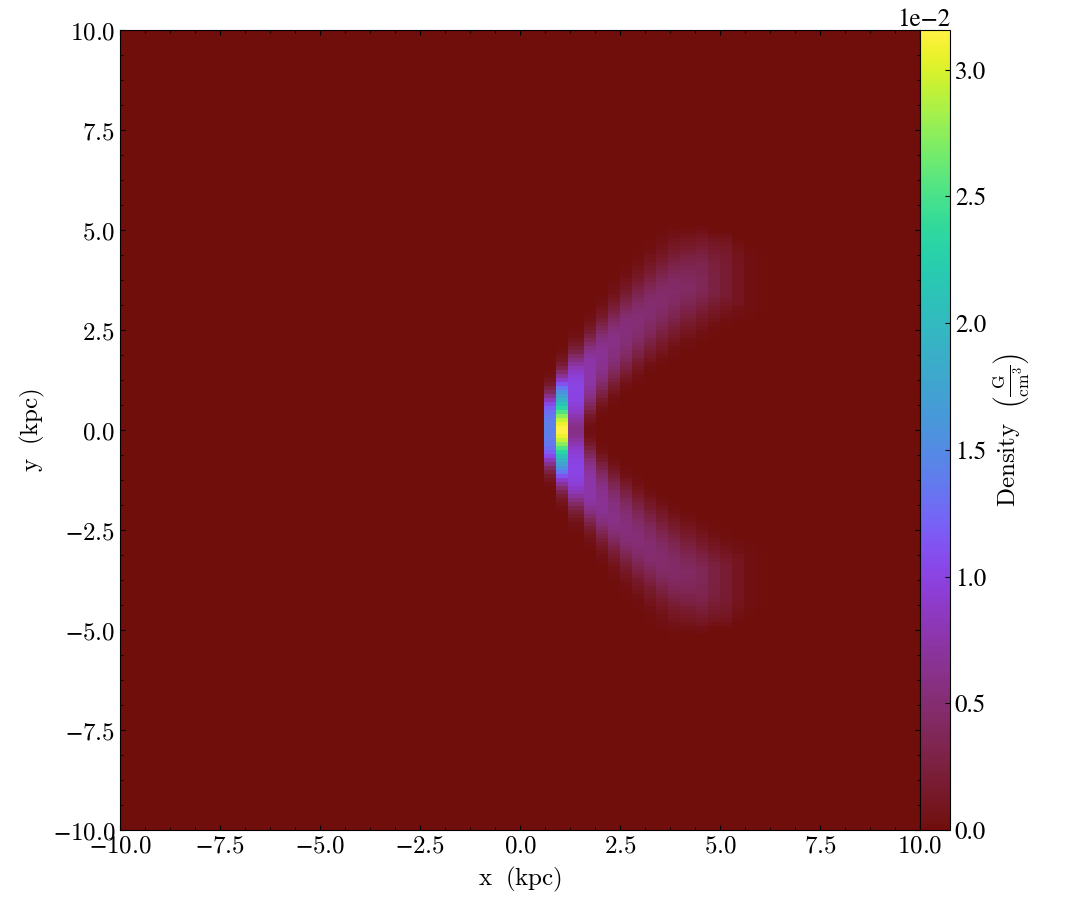

In [18]:
ds_cube2 = yt.load("cube2.fits")
new_center = ds_cube2.domain_center
new_center[2] = ds_cube2.spec2pixel(70.0*u.km/u.s)
slc = yt.SlicePlot(ds_cube2, "z", ["density"], center=new_center)
slc.show()

yt : [INFO     ] 2017-08-10 16:21:54,242 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:54,243 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:54,244 xlim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:54,245 ylim = 0.500000 200.500000
yt : [INFO     ] 2017-08-10 16:21:54,246 Making a fixed resolution buffer of (('fits', 'density')) 800 by 800



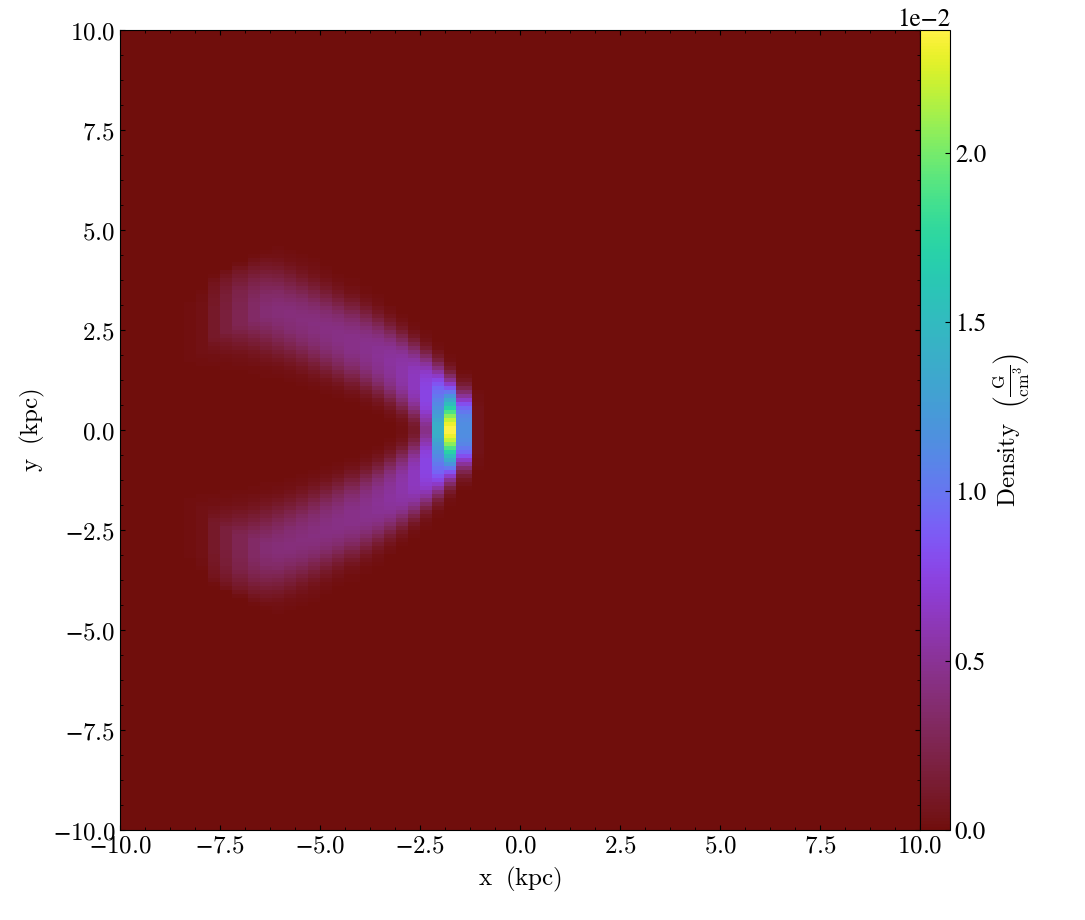

In [19]:
new_center[2] = ds_cube2.spec2pixel(-100.*u.km/u.s)
slc = yt.SlicePlot(ds_cube2, "z", ["density"], center=new_center)
slc.show()

where we can see the emission has been smeared into this velocity slice from neighboring slices due to the thermal broadening. 

Finally, the "velocity" or "spectral" axis of the cube can be changed to a different unit, such as wavelength, frequency, or energy: 

In [20]:
print (cube2.vbins[0], cube2.vbins[-1])
cube2.transform_spectral_axis(400.0,"nm")
print (cube2.vbins[0], cube2.vbins[-1])

-150.0 km/s 150.0 km/s
399.79996163130727 nm 400.20023864575296 nm


If a FITS file is now written from the cube, the spectral axis will be in the new units. To reset the spectral axis back to the original velocity units:

In [21]:
cube2.reset_spectral_axis()
print (cube2.vbins[0], cube2.vbins[-1])

-150.0 km/s 150.0 km/s
